In [ ]:

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import os as os
#import matplotlib.pyplot as plt


In [25]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/miproject')
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/miproject


In [26]:
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/miproject/train'
valid_path = '/content/drive/MyDrive/miproject/test'

In [27]:

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [28]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [29]:
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/miproject/train/*')

In [30]:
x = Flatten()(resnet.output)

In [31]:
prediction = Dense(len(folders), activation='softmax')(x)
# create a model object
model = Model(inputs=resnet.input, outputs=prediction)

In [32]:
# view the structure of the model
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [33]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [34]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [35]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/miproject/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 40 images belonging to 2 classes.


In [36]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/miproject/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 40 images belonging to 2 classes.


In [37]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-37-3b4ec9fc1850>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/30
2/2 [==============================] - 33s 21s/step - loss: 4.4320 - accuracy: 0.3500 - val_loss: 5.8650 - val_accuracy: 0.5000
Epoch 2/30
2/2 [==============================] - 17s 10s/step - loss: 5.0848 - accuracy: 0.4500 - val_loss: 3.7673 - val_accuracy: 0.5000
Epoch 3/30
2/2 [==============================] - 17s 10s/step - loss: 3.8777 - accuracy: 0.5000 - val_loss: 2.7800 - val_accuracy: 0.5000
Epoch 4/30
2/2 [==============================] - 17s 11s/step - loss: 2.4149 - accuracy: 0.5000 - val_loss: 2.6157 - val_accuracy: 0.5000
Epoch 5/30
2/2 [==============================] - 17s 9s/step - loss: 2.5129 - accuracy: 0.5000 - val_loss: 1.7986 - val_accuracy: 0.5000
Epoch 6/30
2/2 [==============================] - 20s 18s/step - loss: 0.7999 - accuracy: 0.5500 - val_loss: 1.6102 - val_accuracy: 0.5000
Epoch 7/30
2/2 [==============================] - 17s 15s/step - loss: 1.7485 - accuracy: 0.5000 - val_loss: 0.7231 - val_accuracy: 0.5500
Epoch 8/30
2/2 [============

In [38]:
import matplotlib.pyplot as plt

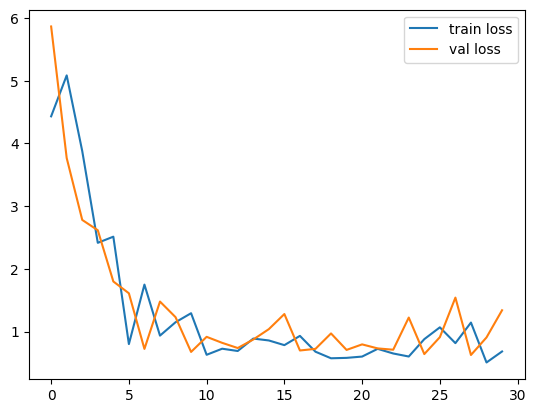

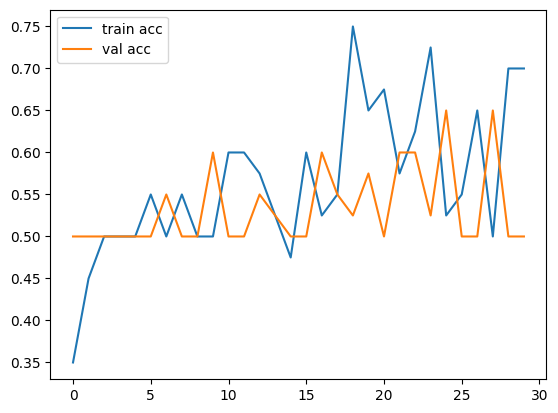

<Figure size 640x480 with 0 Axes>

In [39]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [45]:
# Print the final accuracy
final_train_accuracy = r.history['accuracy'][-1]
final_val_accuracy = r.history['val_accuracy'][-1]
print("Final training accuracy:", final_train_accuracy)
print("Final validation accuracy:", final_val_accuracy)


Final training accuracy: 0.699999988079071
Final validation accuracy: 0.5


In [42]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_resnet50.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
from sklearn.metrics import classification_report

# Predict classes for test set
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred, axis=1)

# Getting the class labels
class_labels = list(training_set.class_indices.keys())

# Getting true labels
true_labels = test_set.classes

# Generate classification report
report = classification_report(true_labels, y_pred, target_names=class_labels, zero_division=1)

print(report)


2/2 [==============================] - 14s 2s/step
              precision    recall  f1-score   support

     Disease       1.00      0.00      0.00        20
 Non-disease       0.50      1.00      0.67        20

    accuracy                           0.50        40
   macro avg       0.75      0.50      0.33        40
weighted avg       0.75      0.50      0.33        40

